In [1]:
import os
data_dir = '/users/Davidaarhus/Documents/CPSC_393'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [2]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

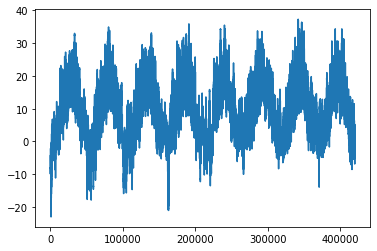

In [6]:
from matplotlib import pyplot as plt

temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)

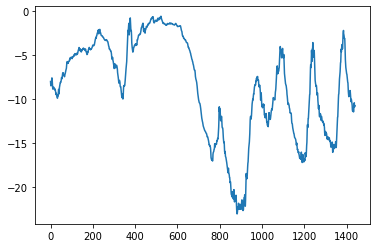

In [7]:
plt.plot(range(1440), temp[:1440])

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
def generator(data, lookback, delay, min_index, max_index,
            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                    lookback // step,
                    data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [21]:
train_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)
val_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)
test_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size)
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [14]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))


In [16]:
#takes to long to evaluate - MAE = 0.29

#evaluate_naive_method()

In [17]:
celsius_mae = 0.29 * std[1]

In [22]:
# training and evaluating a densely connected model

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [24]:
# does not run

# model.compile(optimizer=RMSprop(), loss='mae')
# history = model.fit_generator(train_gen,
#     steps_per_epoch=500,
#     epochs=20,
#     validation_data=val_gen,
#     validation_steps=val_steps)

In [25]:
# plots results, shows that it is overfit

# import matplotlib.pyplot as plt
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.show()

In [27]:
# training and evaluating a GRU-base model
# takes too long, but it will show that yours not longer over-fitting

# from keras.models import Sequential
# from keras import layers
# from keras.optimizers import RMSprop
# model = Sequential()
# model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
# model.add(layers.Dense(1))
    
# model.compile(optimizer=RMSprop(), loss='mae')
# history = model.fit_generator(train_gen,
#     steps_per_epoch=500,
#     epochs=20,
#     validation_data=val_gen,
#     validation_steps=val_steps)

In [29]:
# Training and evaluating a dropout-regularised, stacked GRU model
# results show that it they improve a little but not significantly, you could be sacrificing network capacity at this point

# from keras.models import Sequential
# from keras import layers
# from keras.optimizers import RMSprop
# model = Sequential()
# model.add(layers.GRU(32,
#     dropout=0.1,
#     recurrent_dropout=0.5,
#     return_sequences=True,
#     input_shape=(None, float_data.shape[-1])))
# model.add(layers.GRU(64, activation='relu',
#     dropout=0.1,
#     recurrent_dropout=0.5))
# model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(), loss='mae')
# history = model.fit_generator(train_gen,
#     steps_per_epoch=500,
#     epochs=40,
#     validation_data=val_gen,
#     validation_steps=val_steps)

In [31]:
# Training and evaluating an LSTM using reversed sequences

# you get the same results as a chronological LSTM which shows 

# from keras.datasets import imdb
# from keras.preprocessing import sequence
# from keras import layers
# from keras.models import Sequential

# max_features = 10000
# maxlen = 500

# (x_train, y_train), (x_test, y_test) = imdb.load_data(
# num_words=max_features)

# x_train = [x[::-1] for x in x_train]
# x_test = [x[::-1] for x in x_test]

# x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
# x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

# model = Sequential()
# model.add(layers.Embedding(max_features, 128))
# model.add(layers.LSTM(32))
# model.add(layers.Dense(1, activation='sigmoid'))

# model.compile(optimizer='rmsprop',
#     loss='binary_crossentropy',
#     metrics=['acc'])

# history = model.fit(x_train, y_train,
#     epochs=10,
#     batch_size=128,
#     validation_split=0.2)